# 导包

In [1]:
!pip install --upgrade tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


# 加载数据

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
path="/content/drive/My Drive/Colab Notebooks/NLP/02_Attention/"
data=pd.read_csv(path+"spam.csv",delimiter=',',encoding='latin-1')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


进行预处理

In [3]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


## 平衡数据

Text(0.5, 1.0, 'Number of ham and spam messages')

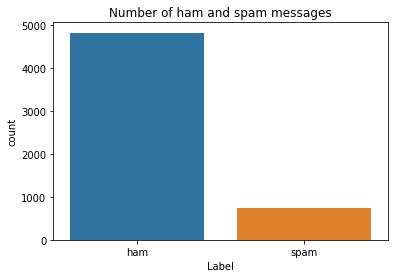

In [4]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [0]:
data_spam=data.loc[data['v1']=='spam']
data_ham=data.loc[data['v1']=='ham']

In [0]:
data=pd.concat([data_ham,data_spam,data_spam,data_spam,data_spam,data_spam,data_spam])

Text(0.5, 1.0, 'Number of ham and spam messages')

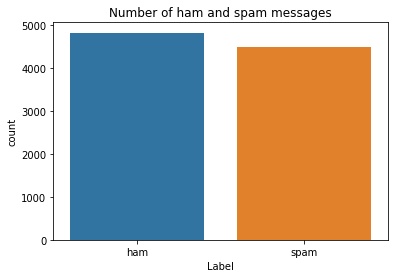

In [8]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [9]:
data=data.sample(frac=1)
data.head()

,v1,v2
4106,spam,HOT LIVE FANTASIES call now 08707500020 Just 2...
4053,ham,dont make ne plans for nxt wknd coz she wants ...
3252,ham,K:)k..its good:)when are you going?
2004,ham,"Goodmorning, today i am late for &lt;DECIMAL&..."
3258,spam,Congratulations! Thanks to a good friend U hav...


## 数据划分

In [0]:
X = data.v2
Y = data.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

## 数据处理

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# 模型

## RNN Model

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [14]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [15]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 5956 samples, validate on 1489 samples
Epoch 1/10
5956/5956 [==============================] - 15s 2ms/sample - loss: 0.2722 - accuracy: 0.9066 - val_loss: 0.0751 - val_accuracy: 0.9772
Epoch 2/10
5956/5956 [==============================] - 13s 2ms/sample - loss: 0.0603 - accuracy: 0.9812 - val_loss: 0.0381 - val_accuracy: 0.9866
Epoch 3/10
5956/5956 [==============================] - 13s 2ms/sample - loss: 0.0331 - accuracy: 0.9891 - val_loss: 0.0247 - val_accuracy: 0.9913
Epoch 4/10
5956/5956 [==============================] - 13s 2ms/sample - loss: 0.0237 - accuracy: 0.9919 - val_loss: 0.0233 - val_accuracy: 0.9886
Epoch 5/10
5956/5956 [==============================] - 13s 2ms/sample - loss: 0.0160 - accuracy: 0.9943 - val_loss: 0.0225 - val_accuracy: 0.9899
Epoch 6/10
5956/5956 [==============================] - 13s 2ms/sample - loss: 0.0094 - accuracy: 0.9968 - val_loss: 0.0198 - val_accuracy: 0.9946
Epoch 7/10
5956/5956 [==============================] - 13s 2ms/sample

In [16]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1862/1862 [==============================] - 1s 667us/sample - loss: 0.0183 - accuracy: 0.9962
Test set
  Loss: 0.018
  Accuracy: 0.996


## Attention Based RNN

In [0]:
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [0]:
def model_attention_applied_after_lstm():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [0]:
from tensorflow.keras.layers import Permute,Reshape,Flatten,multiply
TIME_STEPS = max_len

In [23]:
m = model_attention_applied_after_lstm()
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 150, 50)      50000       inputs[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 150, 64)      29440       embedding_3[0][0]                
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 64, 150)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [24]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m.fit(sequences_matrix,Y_train,batch_size=128,epochs=15,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 5956 samples, validate on 1489 samples
Epoch 1/15
5956/5956 [==============================] - 17s 3ms/sample - loss: 0.6763 - accuracy: 0.5395 - val_loss: 0.5360 - val_accuracy: 0.8381
Epoch 2/15
5956/5956 [==============================] - 15s 3ms/sample - loss: 0.2997 - accuracy: 0.9025 - val_loss: 0.1281 - val_accuracy: 0.9604
Epoch 3/15
5956/5956 [==============================] - 15s 3ms/sample - loss: 0.0901 - accuracy: 0.9710 - val_loss: 0.0688 - val_accuracy: 0.9805
Epoch 4/15
5956/5956 [==============================] - 16s 3ms/sample - loss: 0.0572 - accuracy: 0.9834 - val_loss: 0.0544 - val_accuracy: 0.9879
Epoch 5/15
5956/5956 [==============================] - 15s 3ms/sample - loss: 0.0409 - accuracy: 0.9893 - val_loss: 0.0378 - val_accuracy: 0.9879
Epoch 6/15
5956/5956 [==============================] - 16s 3ms/sample - loss: 0.0281 - accuracy: 0.9928 - val_loss: 0.0249 - val_accuracy: 0.9946
Epoch 7/15
5956/5956 [==============================] - 16s 3ms/sample

In [25]:
accr = m.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1862/1862 [==============================] - 2s 945us/sample - loss: 0.0376 - accuracy: 0.9882
Test set
  Loss: 0.038
  Accuracy: 0.988
